In [11]:
import os
import datetime as dt
import pandas as pd
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import sqlite3
from sqlalchemy import create_engine

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
data = pd.read_csv('../../datafiles/CS1_quora/train.csv')

In [8]:
# avoid decoding problems
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

## We need to do the unicode convergen becasue if we don't, then this error gets fired when we execute the tfidf code
'''
ValueError                                Traceback (most recent call last)
<ipython-input-5-b6e49e49dd9d> in <module>
      1 questions = list(data['question1']) + list(data['question2'])
      2 tfidf = TfidfVectorizer(lowercase=False, )
----> 3 tfidf.fit_transform(questions)
      4 # dict key:word and value:tf-idf score
      5 tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

~\ anaconda3\envs\ml1\lib\site-packages\sklearn\ feature_extraction\ text.py in fit_transform(self, raw_documents, y)
   1839         """
   1840         self._check_params()
-> 1841         X = super().fit_transform(raw_documents)
   1842         self._tfidf.fit(X)
   1843         # X is already a transformed view of raw_documents so

~\ anaconda3\envs\ml1\lib\site-packages\sklearn\ feature_extraction\ text.py in fit_transform(self, raw_documents, y)
   1197 
   1198         vocabulary, X = self._count_vocab(raw_documents,
-> 1199                                           self.fixed_vocabulary_)
   1200 
   1201         if self.binary:

~\ anaconda3\envs\ml1\lib\site-packages\sklearn\ feature_extraction\ text.py in _count_vocab(self, raw_documents, fixed_vocab)
   1108         for doc in raw_documents:
   1109             feature_counter = {}
-> 1110             for feature in analyze(doc):
   1111                 try:
   1112                     feature_idx = vocabulary[feature]

~\ anaconda3\envs\ml1\lib\site-packages\sklearn\ feature_extraction\ text.py in _analyze(doc, analyzer, tokenizer, ngrams, preprocessor, decoder, stop_words)
     97 
     98     if decoder is not None:
---> 99         doc = decoder(doc)
    100     if analyzer is not None:
    101         doc = analyzer(doc)

~\ anaconda3\envs\ml1\lib\site-packages\sklearn\ feature_extraction\ text.py in decode(self, doc)
    217 
    218         if doc is np.nan:
--> 219             raise ValueError("np.nan is an invalid document, expected byte or "
    220                              "unicode string.")
    221 

<h3><font color=red>ValueError: np.nan is an invalid document, expected byte or unicode string.</font></h3>'''

In [11]:
questions = list(data['question1']) + list(data['question2'])
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)
# dict key:word and value:tf-idf score
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [14]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
for qu1 in tqdm(list(data['question1'][0:100000])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = tfidf_dict[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
q1_vect_df = pd.DataFrame(list(vecs1))


100%|██████████| 100000/100000 [10:22&lt;00:00, 160.61it/s]


NameError: name &#39;df&#39; is not defined

In [52]:
vecs2 = []
for qu2 in tqdm(list(data['question2'][0:100000])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = tfidf_dict[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
q2_vect_df = pd.DataFrame(list(vecs1))

100%|██████████| 100000/100000 [10:00&lt;00:00, 166.40it/s]


In [57]:
with open('all_feats.pickle', 'rb') as handle:
    all_feats = pickle.load(handle)
all_feats.columns

Index([&#39;id&#39;, &#39;qid1&#39;, &#39;qid2&#39;, &#39;question1&#39;, &#39;question2&#39;, &#39;is_duplicate&#39;,
       &#39;q1_feq&#39;, &#39;q2_feq&#39;, &#39;q1_len&#39;, &#39;q2_len&#39;, &#39;q1_wrdcnt&#39;, &#39;q2_wrdcnt&#39;,
       &#39;comm_wrds&#39;, &#39;tot_wrtcnt&#39;, &#39;wrd_share&#39;, &#39;add_feq&#39;, &#39;sub_feq&#39;, &#39;q1&#39;,
       &#39;q2&#39;, &#39;ctc_min&#39;, &#39;ctc_max&#39;, &#39;cwc_min&#39;, &#39;cwc_max&#39;, &#39;csc_min&#39;, &#39;csc_max&#39;,
       &#39;start_wrd&#39;, &#39;end_wrd&#39;, &#39;len_diff&#39;, &#39;avg_len&#39;, &#39;fuzz_ratio&#39;,
       &#39;partial_ratio&#39;, &#39;token_sort_ratio&#39;, &#39;token_set_ratio&#39;,
       &#39;longest_substring_len&#39;],
      dtype=&#39;object&#39;)

In [53]:
q2_vect_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,58.907952,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,110.348369,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,115.968702,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,27.243861,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,253.326808,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,50.431833,46.416796,12.426708,-64.581614,113.621014,-54.823904,-103.367449,18.171196,-87.549190,24.744277,...,157.476830,20.444703,12.985929,-10.703484,35.840786,-37.030177,-9.987324,18.476616,77.142565,65.226456
99996,46.921942,-33.907936,-12.220003,-40.109203,26.887653,-28.481168,-51.876124,39.009582,-14.053054,30.907909,...,11.594762,6.775913,-23.255859,-36.634537,95.023611,-11.532416,36.057952,-10.749227,33.401148,-32.235159
99997,31.871186,40.452379,25.536949,59.983472,141.216376,-4.532640,17.796229,73.690377,-49.425923,24.372689,...,30.629485,-19.630359,69.012686,30.027649,-31.114696,24.448875,-104.331569,44.309402,1.425371,-37.907382
99998,54.874772,26.017849,73.237382,-23.073876,108.942851,-37.052761,-95.090122,34.550603,22.451997,102.080223,...,78.987806,14.458624,25.813056,21.272252,16.629934,-11.735951,-88.313945,24.789134,31.729830,-4.310078


In [6]:
cols = ['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_feq', 'q2_feq', 'q1_len', 'q2_len', 'q1_wrdcnt', 'q2_wrdcnt',
       'comm_wrds', 'tot_wrtcnt', 'wrd_share', 'add_feq', 'sub_feq', 'q1',
       'q2', 'ctc_min', 'ctc_max', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'start_wrd', 'end_wrd', 'len_diff', 'avg_len', 'fuzz_ratio',
       'partial_ratio', 'token_sort_ratio', 'token_set_ratio',
       'longest_substring_len','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y']

In [67]:
dataset = pd.concat([all_feats.iloc[0:100000],q1_vect_df,q2_vect_df],axis=1)
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feq,q2_feq,q1_len,q2_len,...,86,87,88,89,90,91,92,93,94,95
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [19]:
dataset.to_csv('datasets/dataset.csv',index=False)

In [66]:
with open('datasets/dataset.pickle', 'wb') as handle:
    pickle.dump(dataset,handle)

In [4]:
with open('datasets/dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [5]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feq,q2_feq,q1_len,q2_len,...,86,87,88,89,90,91,92,93,94,95
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [32]:
#Creating db file from csv
if not os.path.isfile('datasets/quora_data.db'):
    disk_engine = create_engine('sqlite:///quora_data.db')
    start = dt.datetime.now()
    chunksize = 40000
    j = 0
    index_start = 1
    for df in pd.read_csv('datasets/dataset.csv',names=cols, chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('quora_data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

40000 rows
80000 rows
120000 rows


In [39]:
# without chunk size
pd.read_csv('datasets/dataset.csv',names=cols,encoding='utf-8',header=0).to_sql('temp_data', disk_engine, if_exists='append')

Checking if there is the table we just saves in the sqlite 

In [2]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None
    
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

read_db = 'datasets/quora_data.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
quora_data


- Importing the data from sqlite

In [3]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM quora_data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        # data = pd.read_sql_query("SELECT * From quora_data ORDER BY RANDOM() LIMIT 100001;", conn_r)

        #for selecting all the data and we are going to this as we already have only 100000 data in the sqlite
        all_set_data = pd.read_sql_query("SELECT * From quora_data;", conn_r,index_col='id') # OR you can just use the already established connection 'disk_engine' in place of 'conn_r'
        conn_r.commit()
        conn_r.close()
all_set_data

,index,qid1,qid2,question1,question2,is_duplicate,q1_feq,q2_feq,q1_len,q2_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
id,,,,,,,,,,,,,,,,,,,,,
id,1,qid1,qid2,question1,question2,is_duplicate,q1_feq,q2_feq,q1_len,q2_len,...,86.000000,87.000000,88.000000,89.000000,90.000000,91.000000,92.000000,93.000000,94.000000,95.000000
0,2,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,3,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,4,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,5,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,219997,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0,1,1,52,49,...,157.476830,20.444703,12.985929,-10.703484,35.840786,-37.030177,-9.987324,18.476616,77.142565,65.226456
99996,219998,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0,1,4,23,28,...,11.594762,6.775913,-23.255859,-36.634537,95.023611,-11.532416,36.057952,-10.749227,33.401148,-32.235159
99997,219999,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1,2,2,39,58,...,30.629485,-19.630359,69.012686,30.027649,-31.114696,24.448875,-104.331569,44.309402,1.425371,-37.907382


### Other way

In [40]:
pd.read_sql_table('temp_data',disk_engine,index_col='id');

,index,qid1,qid2,question1,question2,is_duplicate,q1_feq,q2_feq,q1_len,q2_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,165922,165923,What are some of the most iconic images of foo...,What are some of the most iconic images of women?,0,1,1,52,49,...,157.476830,20.444703,12.985929,-10.703484,35.840786,-37.030177,-9.987324,18.476616,77.142565,65.226456
99996,99996,165924,165925,How green is green tea?,"Why isn't ""green"" tea green?",0,1,4,23,28,...,11.594762,6.775913,-23.255859,-36.634537,95.023611,-11.532416,36.057952,-10.749227,33.401148,-32.235159
99997,99997,165926,165927,Who would win: Black Panther or Batman?,Who would win in a fight between Black Panther...,1,2,2,39,58,...,30.629485,-19.630359,69.012686,30.027649,-31.114696,24.448875,-104.331569,44.309402,1.425371,-37.907382


In [4]:
# remove the first row 
all_set_data.drop(all_set_data.index[0], inplace=True)
#remove the index column
all_set_data.drop('index',axis=1, inplace=True)

<h3>Converting strings to numerics </h3>
after we read from sql table each entry was read it as a string

In [5]:
print(all_set_data.iloc[20,10])
type(all_set_data.iloc[20,10])

7


str

 we convert all the features into numaric before we apply any model

In [6]:
c = list(all_set_data.columns)
for i in c:
    if i not in ['question1','question2','q1','q2']:
        all_set_data[i] = all_set_data[i].apply(pd.to_numeric)
        print(i)

qid1
qid2
is_duplicate
q1_feq
q2_feq
q1_len
q2_len
q1_wrdcnt
q2_wrdcnt
comm_wrds
tot_wrtcnt
wrd_share
add_feq
sub_feq
ctc_min
ctc_max
cwc_min
cwc_max
csc_min
csc_max
start_wrd
end_wrd
len_diff
avg_len
fuzz_ratio
partial_ratio
token_sort_ratio
token_set_ratio
longest_substring_len
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y
50_y
51_y

- ### Train test split 

In [7]:
# taking the relevant data
x_dt = all_set_data.drop(['question1','question2','q1','q2','qid1','qid2','is_duplicate'],axis=1)
X_train,X_test, Y_train, Y_test = train_test_split(x_dt, all_set_data['is_duplicate'], stratify=all_set_data['is_duplicate'], test_size=0.3)

In [8]:
Y_train.value_counts(normalize=True),Y_test.value_counts(normalize=True)

(0    0.627457
 1    0.372543
 Name: is_duplicate, dtype: float64,
 0    0.627467
 1    0.372533
 Name: is_duplicate, dtype: float64)

- Function for confusion matrix

In [9]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8847769272656755


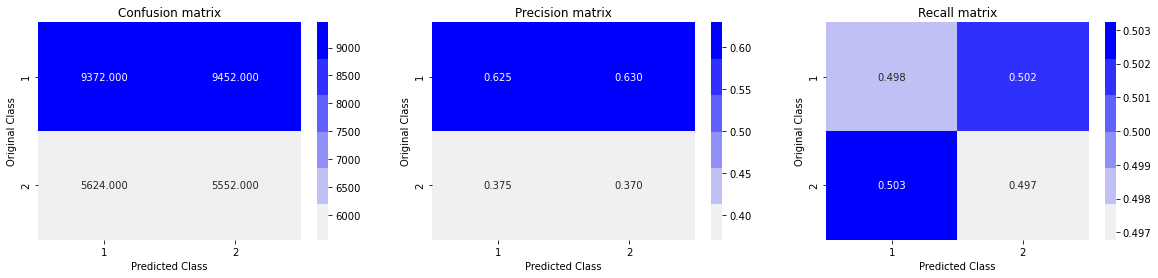

In [10]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((len(Y_test),2))
for i in range(len(Y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

- ## Logistic

Test log losses: [0.44445990956098935, 0.4472919995123814, 0.46887371038441755, 0.4170732214217494, 0.44756601200754975, 0.4626663942810012, 0.5099530707190466]
Best alpha: 0.01
Train Log-loss: 0.40566020361208055
Test Log-loss: 0.4170732214217494


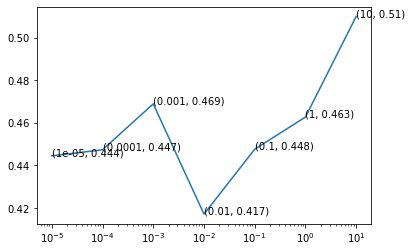

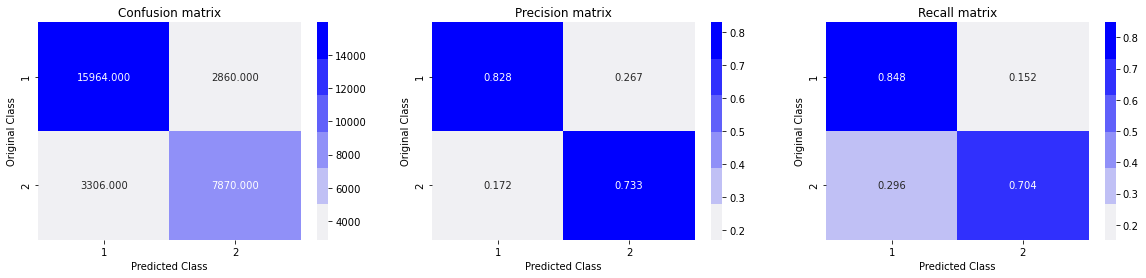

In [38]:
# Logistic classification
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(X_train,Y_train)
    log_calib = CalibratedClassifierCV(log_clf,method='isotonic',cv='prefit')
    log_calib.fit(X_train,Y_train)
    Y_predict_log = log_calib.predict_proba(X_test)
    log_loss_Logi.append(log_loss(Y_test,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(X_train,Y_train)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='isotonic',cv='prefit')
bst_estimator_Logi_calib.fit(X_train,Y_train)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(Y_train,bst_estimator_Logi_calib.predict_proba(X_train),eps=1e-15))
print('Test Log-loss:',log_loss(Y_test,bst_estimator_Logi_calib.predict_proba(X_test),eps=1e-15))
plot_confusion_matrix(Y_test,bst_estimator_Logi.predict(X_test))

In [ ]:
# Logistic classification wihtout the 'prefit=True' in the CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(X_train,Y_train)
    log_calib = CalibratedClassifierCV(log_clf,method='isotonic')
    log_calib.fit(X_train,Y_train)
    Y_predict_log = log_calib.predict_proba(X_test)
    log_loss_Logi.append(log_loss(Y_test,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(X_train,Y_train)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='isotonic')
bst_estimator_Logi_calib.fit(X_train,Y_train)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(Y_train,bst_estimator_Logi_calib.predict_proba(X_train),eps=1e-15))
print('Test Log-loss:',log_loss(Y_test,bst_estimator_Logi_calib.predict_proba(X_test),eps=1e-15))
plot_confusion_matrix(Y_test,bst_estimator_Logi.predict(X_test))

In [39]:
# Logistic classification With method='sigmoid' in CalibratedClassifierCV
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='log',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(X_train,Y_train)
    log_calib = CalibratedClassifierCV(log_clf,method='sigmoid',cv='prefit')
    log_calib.fit(X_train,Y_train)
    Y_predict_log = log_calib.predict_proba(X_test)
    log_loss_Logi.append(log_loss(Y_test,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(X_train,Y_train)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='sigmoid',cv='prefit')
bst_estimator_Logi_calib.fit(X_train,Y_train)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(Y_train,bst_estimator_Logi_calib.predict_proba(X_train),eps=1e-15))
print('Test Log-loss:',log_loss(Y_test,bst_estimator_Logi_calib.predict_proba(X_test),eps=1e-15))
plot_confusion_matrix(Y_test,bst_estimator_Logi.predict(X_test))

 29%|██▊       | 2/7 [02:58&lt;07:25, 89.04s/it]


KeyboardInterrupt: 

- ## Linear SVM

In [ ]:
# linear-SVM classification
log_loss_Logi = []
alphas = [10 ** x for x in range(-5,2)]
for alpha in tqdm(alphas):
    log_clf = SGDClassifier(loss='hinge',penalty='l2',alpha=alpha,random_state=99,n_jobs=-1)
    log_clf.fit(X_train,Y_train)
    log_calib = CalibratedClassifierCV(log_clf,method='isotonic',cv='prefit')
    log_calib.fit(X_train,Y_train)
    Y_predict_log = log_calib.predict_proba(X_test)
    log_loss_Logi.append(log_loss(Y_test,Y_predict_log,eps=1e-15))
''' We should be doing the CV here as we are using the Y_test for getting the best apha which is totally wrong'''
print('Test log losses:',log_loss_Logi)
# plt.plot(alphas,log_loss_Logi) #matplotlib
# plt.show()
sns.lineplot(alphas,log_loss_Logi).set(xscale="log")
ax=plt.gca()
for i, txt in enumerate(np.round(log_loss_Logi,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_loss_Logi[i]))

bst_alpha = alphas[log_loss_Logi.index(min(log_loss_Logi))]
bst_estimator_Logi = SGDClassifier(loss='log',penalty='l2',alpha=bst_alpha,random_state=99,n_jobs=-1)
bst_estimator_Logi.fit(X_train,Y_train)
bst_estimator_Logi_calib = CalibratedClassifierCV(bst_estimator_Logi,method='isotonic',cv='prefit')
bst_estimator_Logi_calib.fit(X_train,Y_train)
print('Best alpha:',bst_alpha)
print('Train Log-loss:',log_loss(Y_train,bst_estimator_Logi_calib.predict_proba(X_train),eps=1e-15))
print('Test Log-loss:',log_loss(Y_test,bst_estimator_Logi_calib.predict_proba(X_test),eps=1e-15))
plot_confusion_matrix(Y_test,bst_estimator_Logi.predict(X_test))